In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
for x in list(df.dtypes.index):
    if x in categorical_columns:
        df[x] = df[x].fillna('NA')
    else:
        df[x] = df[x].fillna(0.0)

In [7]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [14]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Q1
ROC AUC feature importance

In [17]:
from sklearn.metrics import roc_auc_score

In [16]:
numerical_columns = list(df_train.dtypes[df.dtypes != 'object'].index)
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [18]:
for n in numerical_columns:
    auc = roc_auc_score(y_train, df_train[n])
    print(n, auc)

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


# Q2
Training the model

In [21]:
from sklearn.metrics import roc_curve

In [19]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [29]:
y_pred = model.predict_proba(X_val)[:, 1]

In [32]:
y_pr = y_pred > 0.5
round((y_val == y_pr).mean(), 2)

np.float64(0.7)

In [33]:
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.817

In [35]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

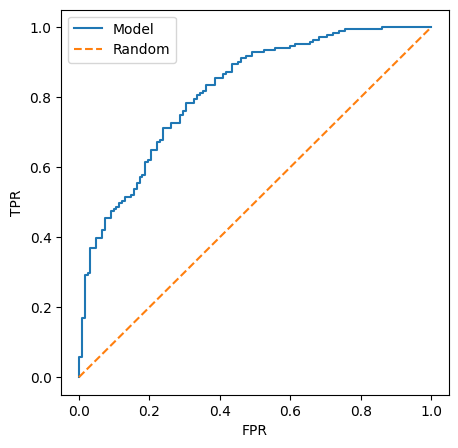

In [36]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# Q3
Precision and Recall

In [49]:
scores = []

for t in np.linspace(0, 1, 101):
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    #print(tp)
    tn = (predict_negative & actual_negative).sum()
    #print(tn)
    
    fp = (predict_positive & actual_negative).sum()
    #print(fp)
    fn = (predict_negative & actual_positive).sum()
    #print(fn)

    if tp + fp == 0:
        p = 0  
    else:
        p = tp / (tp + fp)
    
    if tp + fn == 0:
        r = 0
    else:
        r = tp / (tp + fn)

    scores.append((t, p, r))

In [55]:
scores[:10]

[(np.float64(0.05), np.float64(0.5836177474402731), np.float64(1.0)),
 (np.float64(0.06), np.float64(0.5836177474402731), np.float64(1.0)),
 (np.float64(0.07), np.float64(0.5836177474402731), np.float64(1.0)),
 (np.float64(0.08), np.float64(0.5836177474402731), np.float64(1.0)),
 (np.float64(0.09), np.float64(0.5836177474402731), np.float64(1.0))]

In [56]:
columns = ['threshold', 'Precision', 'Recall']
df_scores = pd.DataFrame(scores, columns=columns)

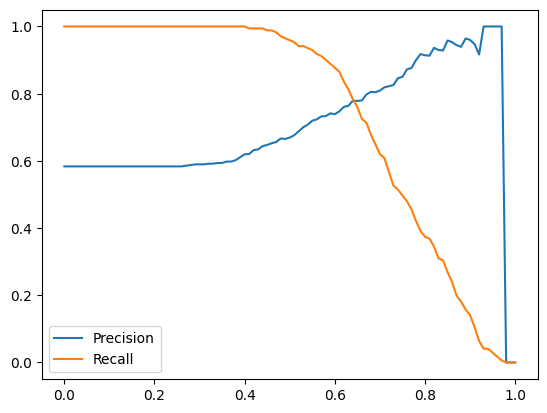

In [58]:
plt.plot(df_scores.threshold, df_scores['Precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['Recall'], label='Recall')
plt.legend()

In [67]:
2 * scores[1][1] * scores[1][2] / (scores[1][1] + scores[1][2])

np.float64(0.7370689655172414)

In [74]:
f1 = []
for s in scores:
    if (s[1] + s[2]) == 0:
        f = 0
    else:
        f = 2 * s[1] * s[2] / (s[1] + s[2])
    f1.append({"threshlod": s[0], "score": f})

In [75]:
best = max(f1, key=lambda x: x["score"])
best

{'threshlod': np.float64(0.5700000000000001),
 'score': np.float64(0.8124999999999999)}

In [76]:
top5 = sorted(f1, key=lambda x: x["score"], reverse=True)[:5]

for item in top5:
    print(item)

{'threshlod': np.float64(0.5700000000000001), 'score': np.float64(0.8124999999999999)}
{'threshlod': np.float64(0.55), 'score': np.float64(0.8112244897959184)}
{'threshlod': np.float64(0.56), 'score': np.float64(0.8092783505154639)}
{'threshlod': np.float64(0.59), 'score': np.float64(0.8085106382978723)}
{'threshlod': np.float64(0.58), 'score': np.float64(0.8083989501312335)}


# Q5
5-Fold CV

In [77]:
!pip install tqdm

In [78]:
from tqdm.auto import tqdm

In [82]:
from sklearn.model_selection import KFold

In [79]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [85]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [86]:
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [90]:
np.std(scores)

np.float64(0.03177873210139216)

# Q6
Hyperparameter Tuning

In [92]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.876 +- 0.032
C=0.001 0.876 +- 0.032
C=1 0.876 +- 0.032
